$\require{mhchem}$
# Analyse AIRSS Search results with different XC
For $\ce{Ag2Se}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Plot VASP refine results

In [2]:
%aiida
import pandas as pd
from aiida.orm import Group, QueryBuilder, StructureData,Code, Computer
# Gruop containing the res structures for easy access
res_structgroup = Group.objects.get(label='ag2se/reduced-xc-test-set')


NotExistent: No result was found

In [5]:
def get_xc_type(param, sfamily):

    if isinstance(param, Dict):
        param = param.get_dict()['vasp']
    else:
        param = param['vasp']
    gga = param.get('gga')
    if sfamily.startswith('LDA') and gga is None :
        return 'lda'
    elif gga is None or gga.upper() == 'PE':
        if param.get('lhfcalc'):
            return 'hse06'
        return 'pbe'
    elif gga == 'ps' and 'ldauu' not in param:
        return 'pbesol'
    else:
        return 'ERROR'
    return None

import re
# Patter matching the name
pat = re.compile(r'([\w\-_]+)\.res')

def get_dataframe(group, lkey=0):
    """Obtained relaxed structures for a particular group"""

    q = QueryBuilder()
    q.append(Group, filters={'id': group.pk})
    q.append(StructureData, with_group=Group, project=['id'])
    q.append(WorkChainNode, with_incoming=StructureData, filters={'attributes.exit_status': {'in': [0, 406, 600]},
                                                                  'process_type': {'like': '%relax'}
                                                                 },
             project=['uuid', 'label'])
    q.append(Str, with_outgoing=WorkChainNode, edge_filters={'label': 'vasp__potential_family'}, project='attributes.value')
    q.append(Dict, with_incoming=WorkChainNode, project=['attributes.total_energies.energy_no_entropy'])
    q.append(StructureData, edge_filters={'label': 'relax__structure'}, with_incoming=WorkChainNode, project=['*', 'id'], edge_project=['label'])
    q.append(Dict, with_outgoing=WorkChainNode, edge_filters={'label': 'vasp__parameters'}, project=['attributes'], 
             filters={'attributes.vasp.encut': 550}
            )
    q.distinct()
    res = q.all()
    
    q = QueryBuilder()
    q.append(Group, filters={'id': group.pk})
    q.append(StructureData, with_group=Group, project=['id'])
    q.append(WorkChainNode, with_incoming=StructureData, filters={'attributes.exit_status': {'in': [0, 406, 600]},
                                                                  'process_type': {'like': '%relax'}
                                                                 },
             project=['uuid', 'label'])
    q.append(Str, with_outgoing=WorkChainNode, edge_filters={'label': 'potential_family'}, project='attributes.value')
    q.append(Dict, with_incoming=WorkChainNode, project=['attributes.total_energies.energy_no_entropy'])
    q.append(StructureData, edge_filters={'label': 'relax__structure'}, with_incoming=WorkChainNode, project=['*', 'id'], edge_project=['label'])
    q.append(Dict, with_outgoing=WorkChainNode, edge_filters={'label': 'parameters'}, project=['attributes'], 
             filters={'attributes.vasp.encut': 550}
            )
    q.distinct()
    res.extend(q.all())
    
    
    results = []
    for spk, rpk, rlabel, family_string,  eng, struct, rspk, calc_param, elabel in res:
        funits = struct.get_pymatgen().composition.get_integer_formula_and_factor()[1]
        name = 'Ag2Se GUNTER' if 'GUNTER' in rlabel else rlabel.split()[lkey] 
        results.append({'label': str(name), 'relax_work': rpk, 'relaxed': rspk, 'energy': eng,
                        'energy_fu': eng / funits, 'nform': funits, 
                        'volume': struct.get_cell_volume(), 
                        'volume_fu': struct.get_cell_volume() / funits,
                        'xc': get_xc_type(calc_param, family_string),
                        'elabel': elabel,
                        **calc_param['vasp']
                       })
    return pd.DataFrame.from_records(results)

In [6]:
def type_string(label):
    if 'mp' in label:
        return r'$P2_12_12_1$'
    elif '20200927' in label:
        return r'Anti-$\mathrm{PbCl_2}$'
    elif 'GUNTER' in label:
        return 'Gunter'
    return 'AIRSS'

In [7]:
# Joint Data Together
dfs = []
exp_structgroup = Group.objects.get_or_create(label='ag2se/gunter/structure')[0]
for resgroup in [res_structgroup, exp_structgroup]:
    res_vasp_df = get_dataframe(resgroup)
    #mp_vasp_df = get_dataframe(mp_struct_group, lkey=1)
    #vasp_df = pd.concat([res_vasp_df, mp_vasp_df], axis=0)
    vasp_df = res_vasp_df
    vasp_df['type'] = vasp_df.label.apply(type_string)
    vasp_df['group'] = resgroup.label
    vasp_df['label'] = vasp_df['label'].str.replace('-P2', '_P2')
    dfs.append(vasp_df)
vasp_df = pd.concat(dfs)

vasp_df['label'] = vasp_df['label'].str.replace('-P2', '_P2')
vasp_df['seed_name'] = vasp_df['label'].apply(lambda x: x.split('-')[0])
vasp_df['energy_pa'] = vasp_df['energy_fu'] / 3 # 3 atoms per unit cell

# Reference for each exchange correlaction functional

Only the relative energies make sense - we use the P2_12_12_1 phase as the reference

In [9]:
vasp_df['energy_pa_ref'] = vasp_df['energy_pa']
for xc in vasp_df.xc.unique():
    mask = (vasp_df.xc == xc)
    ref_eng = vasp_df.loc[mask & (vasp_df['type'] == r'$P2_12_12_1$'), 'energy_pa'].min()
    vasp_df.loc[vasp_df.xc == xc, 'energy_pa_ref'] = vasp_df.loc[vasp_df.xc == xc, 'energy_pa_ref'] - ref_eng

labels = [label.replace('HSE06', '') for label in vasp_df.label]
vasp_df['label'] = labels # Reset the labels

selected = vasp_df[vasp_df.xc == 'hse06'].label.unique()
vasp_df = vasp_df[vasp_df.label.apply(lambda x: x in selected)]

## Generate the H vs V plot

In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

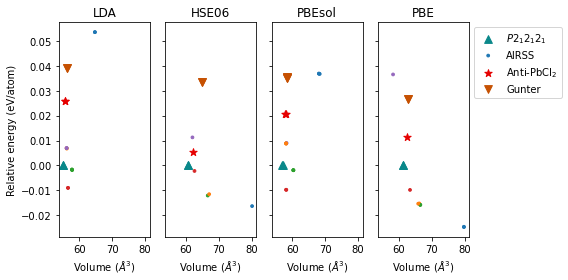

In [11]:
unique_xc = ['lda', 'hse06', 'pbesol', 'pbe']
fig, axs = plt.subplots(1, len(unique_xc), sharex=True, sharey=True, figsize=(8,4))
airss_labels = {}
for i, label in enumerate(vasp_df[vasp_df.type == 'AIRSS'].label.unique()):
    airss_labels[label] = colors[i % len(colors)]
types = [('$P2_12_12_1$', '^', 'xkcd:dark cyan'), ('AIRSS', '.', 'r'), (r'Anti-$\mathrm{PbCl_2}$', '*', 'xkcd:red'), ('Gunter', 'v', 'xkcd:dark orange')]
for xc, ax in zip(unique_xc, axs):
    subset = vasp_df[vasp_df.xc == xc]
    for type_name, marker, color in types:
        subsubset = subset[subset.type == type_name]
        if type_name == 'AIRSS':
            c = [airss_labels[lb] for lb in subsubset.label]
            ax.scatter(subsubset.volume / subsubset.nform, subsubset.energy_pa_ref, label=type_name, marker=marker, c=c, s=30)
        else:
            ax.scatter(subsubset.volume / subsubset.nform, subsubset.energy_pa_ref, label=type_name, marker=marker, c=color, s=60)
        #ax.scatter(subsubset.volume, subsubset.energy_pa_ref, label=type_name, marker=marker)

    ax.set_title(xc.upper() if xc != 'pbesol' else 'PBEsol')
    ax.set_xlabel(r'Volume ($\AA^3$)')
    
axs[-1].legend(bbox_to_anchor=(1, 1.0))
axs[0].set_ylabel('Relative energy (eV/atom)')
fig.tight_layout()
fig.savefig('xc-compared.svg')